In [1]:
!jupyter labextension install jupyterlab-plotly
!jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget

(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
/home/danhan/miniforge3/envs/pipe_dlc/lib/python3.10/site-packages/jupyterlab/debuglog.py:54: UserWarning: An error occurred.
  warnings.warn("An error occurred.")
/home/danhan/miniforge3/envs/pipe_dlc/lib/python3.10/site-packages/jupyterlab/debuglog.py:55: UserWarning: ValueError: Please install nodejs >=20.0.0 before continuing. nodejs may be installed using conda or directly from the nodejs website.
  warnings.warn(msg[-1].strip())
/home/danhan/miniforge3/envs/pipe_dlc/lib/python3.10/site-packages/jupyterlab/debuglog.py:56: UserWarning: See the log file for details: /tmp/jupyterlab-debug-1fzq5rdo.log
  warnings.warn(f"See the log file for details: {log_pat

In [2]:
!pip install argus_gui

In [3]:
cam_list = ["A","B","C"]


In [4]:
import plotly
import plotly.graph_objs as go
from pyvm.classes.videoclass import Videos
import os
import numpy as np
import pandas as pd
from pythonlib.tools.expttools import writeStringsToFile
import matplotlib.pyplot as plt
import cv2
import argus_gui as ag

In [5]:
def extract_P_from_dlt(dltcoefs):
    '''function which recreates the Projection matrix'''
    '''function which recreates the Projection matrix'''
    dltcoefs = np.append(dltcoefs, 0)
    norm = np.linalg.norm(dltcoefs)
    dltcoefs = dltcoefs/norm

    P = dltcoefs.reshape(3,4)
    return P
def triangulate_cv2(dltcoefs,pts):
    """
    Use cv2 to triangulate points, must be done for each pair of cameras and then averaged accross all cams
    INPUTS: 
    dltcoeffs, np array with shape (11,ncams)
    pts, np array with a row for each point, columns are (cam1x,cam1y,cam2x,cam2y...)

    cv2 does normalization so inputting the raw pts and dlt coefs is good 

    RETURNS:
    3d array of xyz pts, one matrix of pts for each frame (1 xyz per frame) 
    (d1 is cam pairs; d2 is number of pts/frames; d3 should be 3 for xyz)
    List telling which cam pair each d1 layer represents
    """
    assert len(dltcoefs[0]) == len(pts[0])/2, f"coefs {len(dltcoefs)} anbd pts {len(pts[0]/2)} not aligned"
    ncams = len(dltcoefs[0])
    cam_pairs = []
    for i in range(ncams):
        for j in range(i+1,ncams):
            cam_pairs.append([i,j])
    #Dataframe to hold the xyz prjections from each cam pair
    pairwise_xyz = []
    for cam_pair in cam_pairs:
        #get coefs and pts for the two cams in question to pass into the internal function
        pair_xyz = triangulate_cv2internal(dltcoefs,pts, cam_pair)
        #There must be a better way to do this
        pairwise_xyz.append(pair_xyz)
    return np.array(pairwise_xyz), cam_pairs
            
def triangulate_cv2internal(dltcoeffs,pts,cams=[0,1]):
    """
    Internal function to call cv2 function for 2 cams. Any size >2 cam pts and dlt coefs can be inputted, 
    will take first two cameras in columns by default. Wanted it to be stand alone ish. 
    See non-internal fxn for inputting format
    """
    #In .mat file with same name as dlt coefs
    cam1_mat = np.array([
        [794,0,452],
        [0,794,508],
        [0,0,1]
    ])
    cam2_mat = np.array([
        [743,0,370],
        [0,743,268],
        [0,0,1]
    ])
    #In checkboard, calibrate_dist.txt
    cam1_distc = np.array([-0.4224, 0.2622, 0.0003, 0.0013, -0.0984])
    cam2_distc = np.array([-0.4122, 0.3531, -0.0001, 0.0010, -0.3494])
    cam1 = cams[0]
    cam2 = cams[1]
    assert cam1 != cam2 and cam1 < cam2, "meowow, bad cams inds"
    cam1_pts = np.array([[p[cam1*2],p[cam1*2+1]-960] for p in pts])
    cam2_pts = np.array([[p[cam2*2],p[cam2*2+1]-528] for p in pts])
    # cam1_pts = np.array([[p[cam1*2],p[cam1*2+1]] for p in pts])
    # cam2_pts = np.array([[p[cam2*2],p[cam2*2+1]] for p in pts])
    cam1_coefs = np.array([p[0] for p in dltcoeffs])
    cam2_coefs = np.array([p[1] for p in dltcoeffs])

    pcam1 = extract_P_from_dlt(cam1_coefs)
    pcam2 = extract_P_from_dlt(cam2_coefs) 

    cam1_undist = cv2.undistortPoints(cam1_pts,cam1_mat,cam1_distc,P=pcam1)
    cam2_undist = cv2.undistortPoints(cam2_pts,cam2_mat,cam2_distc,P=pcam2)
    xyz = []
    for pt1,pt2 in zip(cam1_undist,cam2_undist):
        pt1_homo, pt2_homo = (X.reshape(1,1,2) for X in [pt1,pt2])
        position = cv2.triangulatePoints(pcam1,pcam2,pt1_homo,pt2_homo)
        xyz_pts = cv2.convertPointsFromHomogeneous(position.T).flatten()
        xyz.append(xyz_pts)
    return xyz
def mean_of_stack(stack):
    """
    Function that gets mean of each value of stack of np arrays. (like if you stick a needle at any point in matrix)
    INPUT:
    3d stack of np.arrays you want to take average of
    RETURN:
    one 2d array with means for each position in the stack 
    """
    out = np.zeros((stack.shape[1],stack.shape[2]))
    for i in range(stack.shape[2]):
        for j in range(stack.shape[1]):
            elements_this_ij = []
            for k in range(stack.shape[0]):
                elements_this_ij.append(stack[k,j,i])
            out[j,i] = np.mean(np.array(elements_this_ij))
    return out
                
    

In [6]:
def align_dlt_coefs(dlt_coefs, cols, V):
    import pandas as pd
    """
    Takes dlt coefs, cols, and videoclass object as argument and aligns the dlt coefs with this days ordering
    PARAMS:
    dlt_coefs, usual dlt coefs file loaded as array
    cols, cols as list like object
    V, videoclass object
    RETURN:
    reorganized dlt coefs for this day's data
    """

    # dict_cams = V.get_cameras()
    # cam_list = [c[1][0] for c in dict_cams.items()]
    cam_list=['flea','fly1','bfs1','fly2']

    df = pd.DataFrame(data=dlt_coefs, columns=cols)
    org_array = []

    print("Organizing dlt coeffs ~_~")
    for cam in cam_list:
        org_array.append(list(df[cam]))
    org_array = np.array(org_array).T

    return org_array
        


def dlt_reconstruct(c,camPts, method = "lst_sqs"):
    # assert False, "only use high likelihood points for reconstruction"

    #number of frames
    nFrames=7
    #number of cameras
    nCams=4

    #setup output variables
    xyz = np.empty((nFrames, 3))
    rmse = np.empty((nFrames, 1))

    #process each frame
    for i in range(nFrames):
  
        #get a list of cameras with non-NaN [u,v]
        cdx_size = 0
        cdx_temp=np.where(np.isnan(camPts[i-1,0:int(nCams*2)-1:2])==False, 1, 0)
        for x in range(len(cdx_temp)):
            if cdx_temp[x-1] == 1:
                cdx_size = cdx_size + 1
        cdx = np.empty((1, cdx_size))
        for y in range(cdx_size):
            cdx[0][y] = y+1
        
        # print(cdx_size)
        # assert False

        #if we have 2+ cameras, begin reconstructing
        if cdx_size>=2:
    
            #initialize least-square solution matrices
            m1=np.empty((cdx_size*2, 3))
            m2=np.empty((cdx_size*2, 1))

            temp1 = 0
            temp2 = 0
            for z in range(cdx_size*2):
                if z%2==0:
                    m1[z,0]=camPts[i,(temp1*2)]*c[8,(temp1)]-c[0,(temp1)]
                    m1[z,1]=camPts[i,(temp1*2)]*c[9,(temp1)]-c[1,(temp1)]
                    m1[z,2]=camPts[i,(temp1*2)]*c[10,(temp1)]-c[2,(temp1)]
                    m2[z,0]=c[3,temp1]-camPts[i,(temp1*2)]
                    temp1 = temp1+1
                else:
                    m1[z,0]=camPts[i,(temp2*2)]*c[8,temp2]-c[4,temp2]
                    m1[z,1]=camPts[i,(temp2*2)]*c[9,temp2]-c[5,temp2]
                    m1[z,2]=camPts[i,(temp2*2)]*c[10,temp2]-c[6,temp2]
                    m2[z,0]=c[7, temp2]-camPts[i,(temp2*2)]
                    temp2 = temp2+1
            
            #print(temp1)
            #print(temp2)  
            #get the least squares solution to the reconstruction
            if method == "qr_decomp":
                Q, R = np.linalg.qr(m1) # QR decomposition with qr function 
                y = np.dot(Q.T, m2) # Let y=Q'.B using matrix multiplication 
                x = np.linalg.solve(R, y) # Solve Rx=y
                xyz_pts = x.transpose()
            else:
                xyz_pts = np.linalg.lstsq(m1,m2,rcond=None)[0].T
            xyz[i,0:3]=xyz_pts
            #print(xyz)
            #compute ideal [u,v] for each camera
            #uv=m1*xyz[i-1,0:2].transpose
    
            #compute the number of degrees of freedom in the reconstruction
            #dof=m2.size-3
    
            #estimate the root mean square reconstruction error
            #rmse[i,1]=(sum((m2-uv)**2)/dof)^0.5
    
    return xyz

In [7]:
date = "221015"
expt = "dircolor1"
condition = "behavior"
animal = "Pancho"

V = Videos()
V.load_data_wrapper(date=date, expt=expt, condition=condition, animal=animal)

## Load DLT coefficients
# assert os.path.ispath(path)
path="/home/danhan/Documents/pipeline/dlt_coeffs/no_axis_opt"
dlt_coefs = np.loadtxt(f"{path}/dltCoefs.csv", delimiter=",")
with open(f"{path}/columns.csv", 'r') as file:
    coef_cols = file.read().splitlines()

align_coefs = align_dlt_coefs(dlt_coefs=dlt_coefs, cols=coef_cols, V=V)
assert dlt_coefs.shape == align_coefs.shape

[2, 10]
<class 'list'>
/data3/hand_track/Pancho/221015_dircolor1/behavior
SEARCHIG:  /data3/hand_track/Pancho/221015_dircolor1/behavior
Searching using this string:
/data3/hand_track/Pancho/221015_dircolor1/behavior/Camera1/*vid*.mp4
Found this many paths:
0
Searching using this string:
/data3/hand_track/Pancho/221015_dircolor1/behavior/Camera1/*vid*.avi
Found this many paths:
0
Searching using this string:
/data3/hand_track/Pancho/221015_dircolor1/behavior/fly2/*vid*.mp4
Found this many paths:
453
---
/data3/hand_track/Pancho/221015_dircolor1/behavior/fly2/fly2-vid-t10-downsampled.mp4
---
/data3/hand_track/Pancho/221015_dircolor1/behavior/fly2/fly2-vid-t100-downsampled.mp4
---
/data3/hand_track/Pancho/221015_dircolor1/behavior/fly2/fly2-vid-t101-downsampled.mp4
---
/data3/hand_track/Pancho/221015_dircolor1/behavior/fly2/fly2-vid-t102-downsampled.mp4
---
/data3/hand_track/Pancho/221015_dircolor1/behavior/fly2/fly2-vid-t103-downsampled.mp4
---
/data3/hand_track/Pancho/221015_dircolor1/b

In [8]:
xy_pts = pd.read_csv("/home/danhan/Documents/hand_track/Pancho/221015_dircolor1/track_pts/track_xypts.csv")
xy_pts.columns = [0,1,2,3,4,5,6,7]
xy_pts.head()
xy_pts = np.array(xy_pts)


In [9]:
print(align_coefs)

[[ 9.7067e+02  2.0049e+03  1.0802e+03  1.0633e+03]
 [ 1.7167e+03  5.0467e+01  1.4176e+03  8.7129e+02]
 [-1.2235e+02 -3.3514e+02  2.2673e+03 -3.7350e+02]
 [ 2.1926e+02  2.3512e+02  7.4281e+02  2.6571e+02]
 [-5.9527e+02  5.5436e+02 -1.1343e+03  3.8531e+00]
 [ 8.9287e+02  7.7670e+02  2.7063e+03  8.5906e+02]
 [ 1.7886e+03  1.8348e+03 -8.8090e+01  1.1064e+03]
 [ 6.1857e+02  2.7898e+02  4.0048e+02  3.6257e+02]
 [-1.1546e+00  8.5638e-01  1.0166e+00 -4.8650e-01]
 [ 1.4921e+00  2.2716e+00  1.4847e+00  1.9161e+00]
 [-1.1847e-01 -3.1724e-01 -2.0297e-01 -5.3449e-01]]


In [38]:
# xyz = dlt_reconstruct(align_coefs, xy_pts, method="qr_decomp")
# xyz = dlt_reconstruct(dlt_coefs, xy_pts)
# xyz_all = triangulate_cv2internal(align_coefs,xy_pts)
# xyz = mean_of_stack(xyz_all)
cam1_distc = np.array([-0.4224, 0.2622, 0.0003, 0.0013, -0.0984])
cam2_distc = np.array([-0.4122, 0.3531, -0.0001, 0.0010, -0.3494])
list_dist = list(np.array([cam1_distc,cam2_distc]).T)
# xyz = ag.triangulate.multiTriangulator(xy_pts[:,0:3],list_dist)
xyz_add1 = np.array([
    [-0.0247,-0.1910,-0.3544],
    [-0.0574,-0.1710,-0.2922],
    [-0.0189,-0.1516,-0.2282],
    [0.0496,-0.1562,-0.2636],
    [0.0234,-0.1693,-0.2916],
    [-0.1248,-0.2198,-0.4365],
    [-0.0823,-0.1159,-0.1220]
])

xyz_add2=np.array([
    [0.111336659509839,	0.184587439792231,	0.0961453538756677],
    [0.179970739744559,	0.134828384644768,	0.0866710320759835],
    [0.129199128697755,	0.0487684238148954,	0.0933300606440970],
    [0.00323531288270579,	0.0499384626522935,	0.104222203420653],
    [0.0483512212860489,	0.0950488649062821,	0.102884671518032],
    [0.233379342592683,	0.298073941762581,	0.0816286472221896],
    [0.309248441149595,	-0.0182841158513565,	0.0707561120459978]
])
# xyz=np.loadtxt("/home/danhan/Documents/hand_track/Pancho/221015_dircolor1/3strokes_cam.txt")
# xyz = np.concatenate((xyz,xyz_add))
# xyz = xyz[:,[0,1,2]]
xyz = np.concatenate((xyz_add1,xyz_add2))

xyz_df = pd.DataFrame(xyz)
# fig = plt.figure
# ax = plt.axes(projection='3d')
# for i,p in enumerate(xyz):
#     ax.scatter3D(p[0],p[1],p[2], label = f"point {i}")
#     ax.legend()
# plt.show()
# for i,p in enumerate(xyz):
#     plt.scatter(x=-p[1],y=-p[0],label=f"point {i+1}")
# plt.legend()
# plt.show()
print(xyz_df.head())

        0       1       2
0 -0.0247 -0.1910 -0.3544
1 -0.0574 -0.1710 -0.2922
2 -0.0189 -0.1516 -0.2282
3  0.0496 -0.1562 -0.2636
4  0.0234 -0.1693 -0.2916


In [39]:
xs = [p for p in xyz_df[0]]
ys = [p for p in xyz_df[1]]
zs = [p for p in xyz_df[2]]

# Assign a unique color for each point
colors = ['red', 'green', 'blue', 'purple', 'orange', 'yellow', 'pink']

# Create hover labels for each point


# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=xs,
    y=ys,
    z=zs,
    mode='markers+text',  # 'markers+text' to display text
    marker=dict(
        size=10,
        color=colors,  # Color each point differently
    ),
    # text=labels,  # Label each point
    hoverinfo='text',  # Display only the label on hover
)])

# Customize the layout
fig.update_layout(
                  scene=dict(
                      xaxis_title='X Axis',
                      yaxis_title='Y Axis',
                      zaxis_title='Z Axis'),
    width=1200,
    height=800,
                  showlegend=False)  # Disabling legend as Scatter3d doesn't support categorical legends well

# Show the figure
fig.show()

In [19]:
xyz = np.array([
    [-0.0247,-0.1910,-0.3544],
    [-0.0574,-0.1710,-0.2922],
    [-0.0189,-0.1516,-0.2282],
    [0.0496,-0.1562,-0.2636],
    [0.0234,-0.1693,-0.2916],
    [-0.1248,-0.2198,-0.4365],
    [-0.0823,-0.1159,-0.1220]
])


print(xyz)
xyz_df = pd.DataFrame(xyz)

[[-0.0247 -0.191  -0.3544]
 [-0.0574 -0.171  -0.2922]
 [-0.0189 -0.1516 -0.2282]
 [ 0.0496 -0.1562 -0.2636]
 [ 0.0234 -0.1693 -0.2916]
 [-0.1248 -0.2198 -0.4365]
 [-0.0823 -0.1159 -0.122 ]]


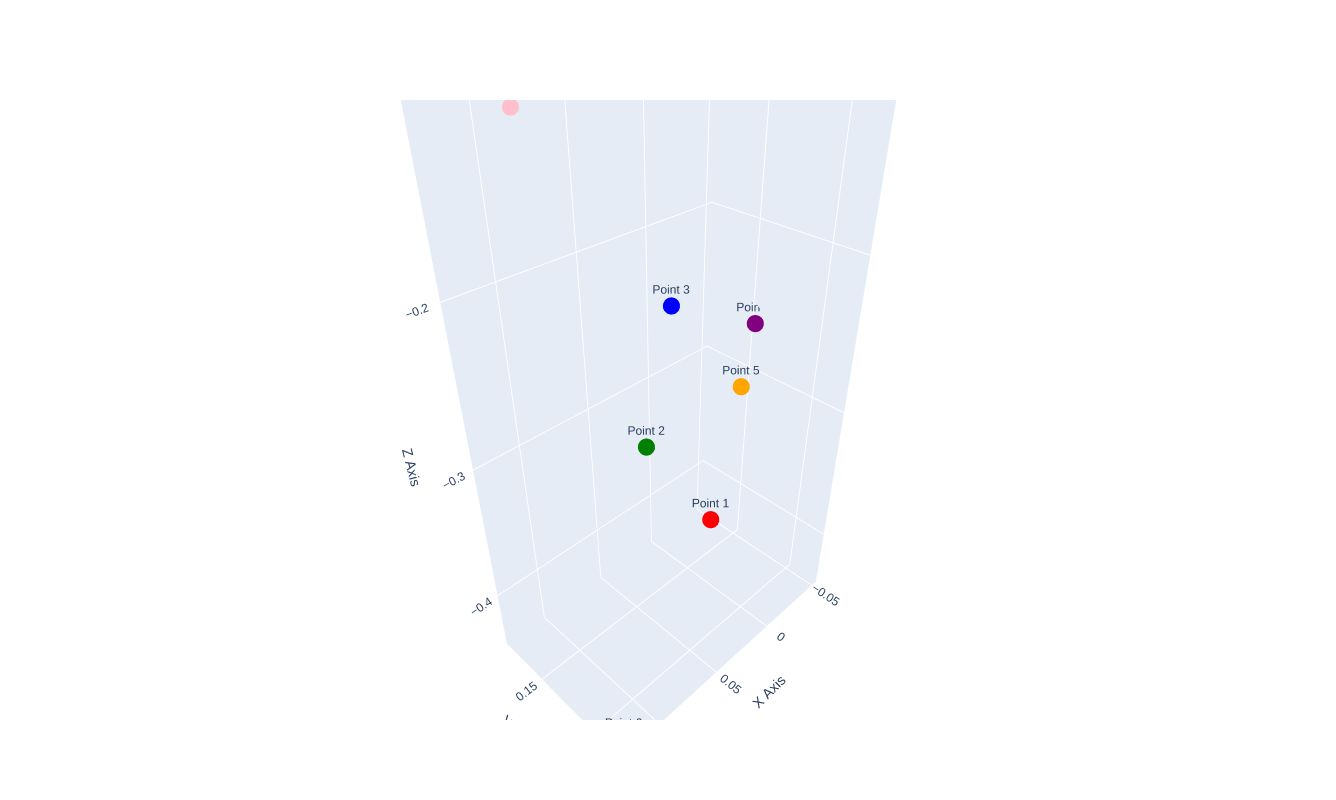

In [20]:
xs = [-p for p in xyz_df[0]]
ys = [-p for p in xyz_df[1]]
zs = [p for p in xyz_df[2]]

# Assign a unique color for each point
colors = ['red', 'green', 'blue', 'purple', 'orange', 'yellow', 'pink']

# Create hover labels for each point
labels = [f'Point {i+1}' for i in range(len(xs))]

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=xs,
    y=ys,
    z=zs,
    mode='markers+text',  # 'markers+text' to display text
    marker=dict(
        size=10,
        color=colors,  # Color each point differently
    ),
    text=labels,  # Label each point
    hoverinfo='text',  # Display only the label on hover
)])

# Customize the layout
fig.update_layout(
                  scene=dict(
                      xaxis_title='X Axis',
                      yaxis_title='Y Axis',
                      zaxis_title='Z Axis'),
    width=1200,
    height=800,
                  showlegend=False)  # Disabling legend as Scatter3d doesn't support categorical legends well

# Show the figure
fig.show()